In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import os
import torch
from torch import nn
from d2l import torch as d2l
import time
from sklearn.metrics import f1_score
from torch.nn import functional as F
from sklearn.metrics import confusion_matrix
import seaborn as sn

In [2]:
path = "F:/Document/France/ENPC/Cours/S5/Projet/data/"
os.chdir(path)
df_data = pd.read_csv("alldata.csv", header=0)
df_data = df_data.dropna()
df_data = df_data.drop(df_data[df_data['Exploitable'] == 0].index)

In [3]:
list_vitesse = []
for i in df_data['Vitesse']:
    list_vitesse.append(eval(i))

list_frf_reel = []
for i in df_data['FRF réel']:
    list_frf_reel.append(eval(i))

list_frf_imag = []
for i in df_data['FRF imag']:
    list_frf_imag.append(eval(i))

In [5]:
np_vitesse = np.array(list_vitesse)
np_frf_reel = np.array(list_frf_reel)
np_frf_imag = np.array(list_frf_imag)
np_frf = np.sqrt(np.square(np_frf_reel) + np.square(np_frf_imag))
np_frq1 = df_data['Fréquences 1'].values

In [8]:
np_frq1 = np_frq1.reshape(len(np_frq1), 1)
np_data = np.concatenate((np_vitesse, np_frf, np_frq1), axis=1)
np.random.shuffle(np_data)

In [9]:
np_vitesse = np_data[:, :614]
np_frf = np_data[:, 614:1228]
np_frq1 = np_data[:, 1228:]

In [11]:
ts_vitesse = torch.tensor(np_vitesse, dtype=torch.float32).reshape(np_vitesse.shape[0], 1, np_vitesse.shape[1])
ts_frf = torch.tensor(np_frf, dtype=torch.float32).reshape(np_frf.shape[0], 1, np_frf.shape[1])
ts_frq1 = torch.tensor(np_frq1, dtype=torch.float32)
ts_feature = torch.concat((ts_vitesse, ts_frf), dim=1)

In [43]:
threshold1 = int(0.6*ts_feature.shape[0])
threshold2 = int(0.8*ts_feature.shape[0])
X_train_v = ts_vitesse[:threshold1]
X_train_f = ts_frf[:threshold1]
X_train = ts_feature[:threshold1]
Y_train = ts_frq1[:threshold1]
X_valid_v = ts_vitesse[threshold1:threshold2]
X_valid_f = ts_frf[threshold1:threshold2]
X_valid = ts_feature[threshold1:threshold2]
Y_valid = ts_frq1[threshold1:threshold2]
X_test_v = ts_vitesse[threshold2:]
X_test_f = ts_frf[threshold2:]
X_test = ts_feature[threshold2:]
Y_test = ts_frq1[threshold2:]

In [13]:
net_v_lenet = nn.Sequential(
              nn.Conv1d(1, 6, kernel_size=5, stride=2,
                        padding=2), nn.ReLU(),
              nn.MaxPool1d(kernel_size=2, stride=2),
              nn.Conv1d(6, 16, kernel_size=5,
                        padding=2), nn.ReLU(),
              nn.MaxPool1d(kernel_size=2, stride=2),
              nn.Flatten(),
              nn.Linear(1216, 120), nn.ReLU(),
              nn.Linear(120, 84), nn.ReLU(),
              nn.Linear(84, 1))

In [ ]:
563, 1044.4, 1432.6, 1665.2

In [35]:
def map_to_class(y, device):
    list_class = []
    for i in y:
        if i < 563:
            i = 4
        elif i >= 563 and i < 1044.4:
            i = 3
        elif i >= 1044.4 and i < 1432.6:
            i = 2
        elif i >= 1432.6 and i < 1665.2:
            i = 1
        else:
            i = 0
        list_class.append(i)
    list_class = torch.FloatTensor(list_class)
    return list_class

In [40]:
def try_gpu(i=0):
    """if gpu exist, return gpu(i), otherwise, return cpu()"""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

def accuracy(y_hat, y):
    # if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
    #     y_hat = y_hat.argmax(axis=1)
    # y = y.argmax(axis=1)
    y_hat = map_to_class(y_hat)
    y = map_to_class(y)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

def evaluate_accuracy_gpu(net, data_iter, device=None):
    if not device: 
        device = try_gpu()
    metric = d2l.Accumulator(2) 
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        metric.add(accuracy(net(X), y), y.shape[0])
    return metric[0] / metric[1]

In [41]:
def train_accuracy(net, X_train, Y_train, X_valid, Y_valid, num_epochs, lr, weight_decay, batch_size, device):
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    train_iter = d2l.load_array((X_train, Y_train), batch_size)
    test_iter = d2l.load_array((X_valid, Y_valid), batch_size,
                               is_train=False)
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr=lr,
                                 weight_decay=weight_decay)
    loss = nn.MSELoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

In [47]:
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
num_epochs, lr, weight_decay, batch_size, device = 10, 1e-3, 0, 64, try_gpu()

loss 11438.430, train acc 0.719, test acc 0.742
345.0 examples/sec on cuda:0


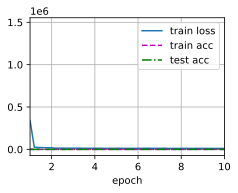

In [48]:
train_accuracy(net_v_lenet, X_train_f, Y_train, X_valid_f, Y_valid, num_epochs, lr, weight_decay, batch_size, device)

In [49]:
class Residual1d(nn.Module):
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv1d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv1d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv1d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm1d(num_channels)
        self.bn2 = nn.BatchNorm1d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))  # conv1 +batchnorm + relu
        Y = self.bn2(self.conv2(Y))  # conv2 + batchnorm
        if self.conv3:
            X = self.conv3(X)
        Y += X   # residual + base
        return F.relu(Y)

def resnet_block1d(input_channels, num_channels, num_residuals,
                   first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual1d(input_channels, num_channels,
                                  use_1x1conv=True, strides=2))
        else:
            blk.append(Residual1d(num_channels, num_channels))
    return blk

# stage1, length / 2
b1 = nn.Sequential(nn.Conv1d(2, 16, kernel_size=7, stride=2, padding=3),
                    nn.BatchNorm1d(16), nn.ReLU(),
                    nn.MaxPool1d(kernel_size=3, stride=2, padding=1))
# stage2, keep form
b2 = nn.Sequential(*resnet_block1d(16, 16, 2, first_block=True))
# stage3, channel * 2
b3 = nn.Sequential(*resnet_block1d(16, 32, 2))
# stage4, channel * 2, length / 2
b4 = nn.Sequential(*resnet_block1d(32, 64, 2))
b5 = nn.Sequential(*resnet_block1d(64, 128, 2))
net_resnet = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool1d((1)),
                    nn.Flatten(), nn.Linear(128, 1))

loss 7475.585, train acc 0.818, test acc 0.798
305.7 examples/sec on cuda:0


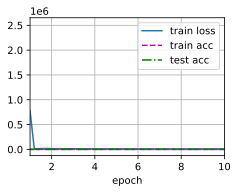

In [50]:
train_accuracy(net_resnet, X_train, Y_train, X_valid, Y_valid, num_epochs, lr, weight_decay, batch_size, device)